In [1]:
%config InlineBackend.figure_formats = ['svg']
%run ../coronavirus.py

- Some plots look a little suspicous /  misleading
- lots of noise
- code base could do with refactoring
- explore that here

In [194]:
def compute_change(series):
    return series.diff()

def compute_rolling_mean(series):
    return series.rolling(7, center=True).mean()

def compute_smooth_gaussian(series, win=5, std=3, ):
    return series.rolling(win, win_type='gausian').mean(std=std)

def compute_smooth_diff(series):
    # 


In [406]:
def plot_change_bar_dev(ax, series, color, rolling=None):
    change = series.diff().dropna()   # lose one point at beginning
    
    if rolling:
        rolling_label = f" {rolling}-day rolling mean"
        # average over 7 days to get rid of reporting cycle - we lose the last 3.5 days for this smoothed line
        # rolling_series = change.rolling(7, center=True).mean()
        # additional smoothing of line, only for visual reasons
        rolling_series = change.rolling(9, center=True, win_type='gaussian', min_periods=1).mean(std=3)
        # extra smoothing for better visual effects
        rolling_series2 = rolling_series.rolling(4, center=True, win_type='gaussian', min_periods=1).mean(std=2)
        
        bar_alpha = 0.2
    else:
        rolling_label = ""
        bar_alpha = 1.0

    label = series.country + " new " + series.label
    ax.bar(change.index, change.values, color=color, label=label, alpha=bar_alpha,
           linewidth=LW)
    if rolling:
        ax.plot(rolling_series.index, rolling_series.values, color=color, label=label + rolling_label, linewidth=0.5)
        ax.plot(rolling_series2.index, rolling_series2.values, color='C3', label="rolling gaussian",
                linewidth=LW)

        ax.legend()
    ax.set_ylabel('daily change')
    
    # exploration
    if False:
        r2 = change.rolling(window=7, win_type='gaussian', 
                            center=True).mean(std=7)
        ax.plot(r2.index, r2.values, color='C2', 
                label= "r2", linewidth=LW+2, linestyle='-.')

    return ax, rolling_series2



In [407]:
country = "Germany"
region, subregion = None, None
c, d = get_country_data(country, region=region, subregion=subregion)
if False:
    c2 = c.drop(c[c.index > '2020-03-15'].index)
    d2 = d.drop(d[d.index > '2020-03-15'].index)
    # c2.loc['2020-04-01'] =  np.nan # c2.loc['2020-03-31']
    c2 = c2.dropna()
else:
    c2 = c
    d2 = d
c2.country = country
c2.label = c.label
d2.label = d.label
d2.country = d.country


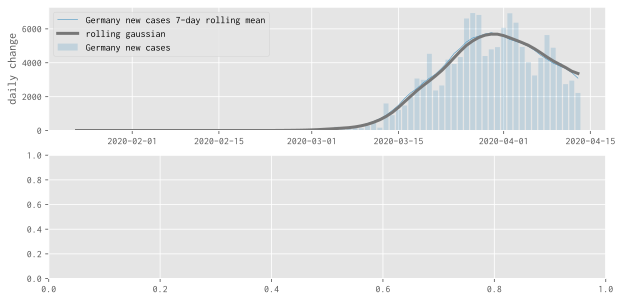

In [408]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=False)
ax = axes[0]
# ax.set_ylim([-50, 200])
_, rolling2 = plot_change_bar_dev(ax=ax, series=c2, rolling=7, color="C1");
#ax = axes[1]

#plot_change_bar_dev(ax=ax, series=d2, rolling=7, color="C0")

In [423]:
def plot_growth_factor_dev(ax, series, color, minchange=10):
    """relative change of number of new cases/deaths from day to day
    See https://youtu.be/Kas0tIxDvrg?t=330, 5:30 onwards
    """
    # only keep values where there is a change of a minumum number
    
    country, label = series.country, series.label
    
    change = series.diff().dropna()   # lose one point at beginning
   
    change = change.rolling(7, center=True, win_type='gaussian', min_periods=1).mean(std=3)
    # series = series.copy(deep=True)
    
    #sel = change.diff() <= minchange
    #series = series.drop(series[sel].index, inplace=False)
    
    f = change.pct_change() + 1  # compute ratio of subsequent daily changes
                                         # use change over a week
    rolling = f.rolling(5, center=True, win_type='gaussian', min_periods=2).mean(std=2)
    
    f.country, f.label = country, label
    # division by zero may lead to np.inf in the data: get rid of that
    # f.replace(np.inf, np.nan, inplace=True)
    # f.dropna(inplace=True)

    # for very small case numbers, we get large growth factors (for example 1 death one day, followed by 7 the next)
    # we drop those high values.
    if False:
        sel = change < 1
        f.drop(f[sel].index, inplace=True)
        values_dropped = sel.sum()
        if values_dropped >= 5:
            print(f"Dropping {values_dropped} from growth factor plot ({series.country}, {series.label})")

    # drop on small values in change
    if False:
        sel = change > 10000
        f.drop(f[sel].index, inplace=True)
        values_dropped = sel.sum()
        if values_dropped >= 5:
            print(f"Dropping {values_dropped} from growth factor plot ({series.country}, {series.label})")

    label = series.country + " " + series.label + " growth factor"
    ax.plot(f.index, f.values, 'o', color=color, alpha=0.3, label=label)
    #rolling = f.rolling(7, center=True).mean()
    # rolling.dropna(inplace=True)

    label = series.country + " " + series.label + " growth factor 7-day mean"
    ax.plot(rolling.index, rolling.values, '-', color=color, label=label, linewidth=LW)

    ## looks much nicer - should we use this?
    # rolling2 = rolling.rolling(7, center=True).mean()
    # rolling2.dropna(inplace=True)
    # label = series.country + " " + series.label + " growth factor 7-day mean"
    # ax.plot(rolling2.index, rolling2.values, '-', color='C4', label=label, linewidth=LW)

    ax.legend()
    ax.set_ylabel("growth factor")
    ax.set_ylim(0.5, 1.5)  # should generally be below 1
    #ax.plot([series.index.min(), series.index.max()], [1.0, 1.0], '-C3') # label="critical value"
    return ax, rolling, f, change


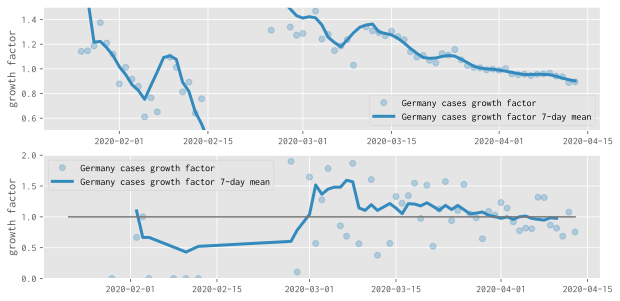

In [424]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=False)
ax = axes[0]
_, rolling, f, change = plot_growth_factor_dev(ax=ax, series=c2, color="C1");
ax = axes[1]
plot_growth_factor(ax=ax, series=c2, color="C1");

In [385]:
change.values

array([0.00000000e+00, 1.41080316e-01, 5.13797691e-01, 5.86734083e-01,
       6.72550360e-01, 7.97779020e-01, 1.09681845e+00, 1.32656365e+00,
       1.48463563e+00, 1.30367332e+00, 1.31965198e+00, 1.20927296e+00,
       1.03733690e+00, 6.33541049e-01, 4.84635631e-01, 3.15561480e-01,
       5.44117184e-01, 5.96204153e-01, 6.03598737e-01, 4.90801622e-01,
       4.37828664e-01, 2.80642674e-01, 2.12577039e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.06288519e-01, 1.20320653e+00,
       3.58846531e+00, 4.71162330e+00, 8.64338965e+00, 1.52298008e+01,
       2.03872410e+01, 2.59492428e+01, 3.33905079e+01, 5.68769515e+01,
       8.35363102e+01, 1.03750422e+02, 1.32649672e+02, 1.52265466e+02,
       1.80557852e+02, 2.23292247e+02, 2.29802303e+02, 3.87675567e+02,
       5.19310570e+02, 6.79474992e+02, 8.78819144e+02, 1.11481320e+03,
       1.45473957e+03, 1.83480830e+03, 2.26937575e+03, 2.58580174e+03,
      

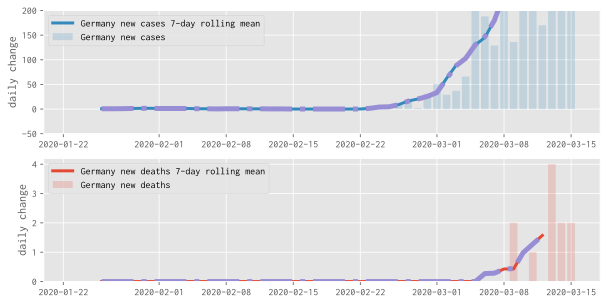

In [138]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=False)
ax = axes[0]
ax.set_ylim([-50, 200])
plot_change_bar_dev(ax=ax, series=c2, rolling=7, color="C1")
ax = axes[1]

plot_change_bar_dev(ax=ax, series=d2, rolling=7, color="C0")

In [86]:
country = "Germany"
region, subregion = None, None
c, d = get_country_data(country, region=region, subregion=subregion)
c2 = c.drop(c[c.index < '2020-03-15'].index)
d2 = d.drop(d[d.index < '2020-03-15'].index)
c2.loc['2020-04-01'] =  np.nan # c2.loc['2020-03-31']
c2 = c2.dropna()

c2.country = country
c2 = c.drop(c[c.index < '2020-03-15'].index)
d2 = d.drop(d[d.index < '2020-03-15'].index)
c2.country = c.country
d2.country = d.country
c2.label = c.label
d2.label = d.label


In [4]:
def overview(country, region=None, subregion=None, savefig=False):

    c, d = get_country_data(country, region=region, subregion=subregion)

    fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=False)
    ax = axes[0]
    plot_time_step(ax=ax, series=c, style="-C1")
    plot_time_step(ax=ax, series=d, style="-C0")

    ax = axes[1]
    plot_change_bar_dev(ax=ax, series=c, rolling=7, color="C1")
    if country == "China":
        ax.set_ylim(0, 5000)

    ax = axes[2]
    plot_change_bar(ax=ax, series=d, rolling=7, color="C0")

    ax = axes[3]
    plot_growth_factor(ax, series=d, color="C0")
    plot_growth_factor(ax, series=c, color="C1")

    ax = axes[4]
    plot_doubling_time(ax, series=d, color="C0")
    plot_doubling_time(ax, series=c, color="C1")

    # enforce same x-axis on all plots
    for i in range(1, 5):
        axes[i].set_xlim(axes[0].get_xlim())
    for i in range(0, 5):
        axes[i].tick_params(left=True, right=True, labelleft=True, labelright=True)
        axes[i].yaxis.set_ticks_position('both')


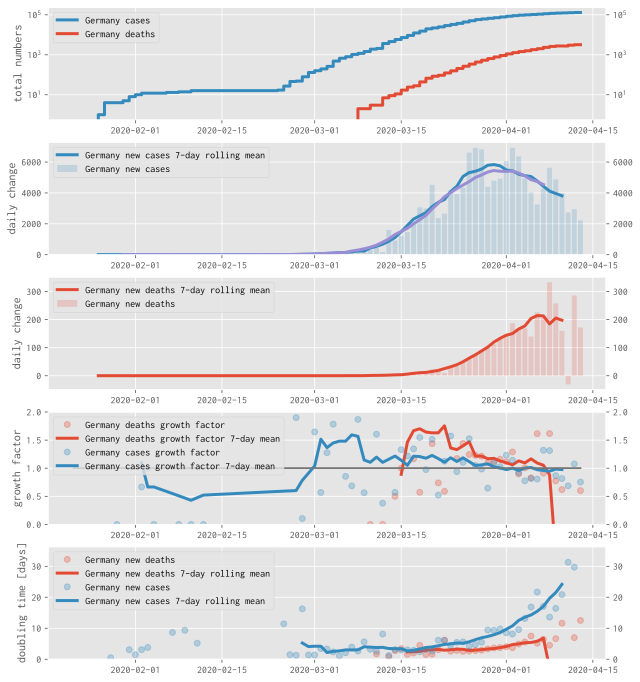

In [5]:
overview('Germany');

In [204]:
import numpy as np

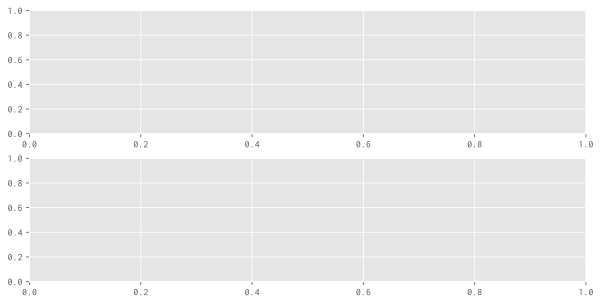

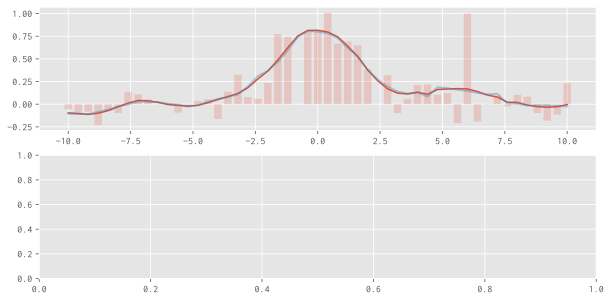

In [353]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=False)
ax = axes[0]
n = 51
x = np.linspace(-10, 10, n)
x0 = 0
sigma = 2
data = np.exp(-(x-x0)**2/sigma**2) + (np.random.uniform(size=n) - 0.5) * 0.5 

s = pd.Series(data=data, index=x)

s.iloc[n//2-2] = np.nan

s.iloc[n//2+15] = 1

ax.bar(s.index, s.values, alpha=0.2, width=0.3)
rgauss = s.rolling(7, center=True).mean()
rmean = s.rolling(7, center=True, win_type='gaussian', min_periods=1).mean(std=2)
rgauss = s.rolling(7, center=True, win_type='gaussian', min_periods=1).mean(std=3)
ax.plot(rmean.index, rmean.values, '-', label='box')
ax.plot(rgauss.index, rgauss.values, '-', linewidth=2, alpha=0.4, label='gaussian')

In [354]:
print("s     ", s.sum())
print("rmean ", rmean.sum())
print("gaus  ", rgauss.sum())


s      8.461840213623914
rmean  9.068316848398469
gaus   9.034355145596704


<BarContainer object of 50 artists>